## The APA-DDoS Experiment!

In [1]:
import os
import vote
import pickle
import warnings
import functools
import numpy as np
import portion as P
import pandas as pd
from tqdm import tqdm
from collections import Counter
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from scipy.spatial.distance import cosine
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [2]:
repo_dir = "APA-DDOS"
if not os.path.exists(repo_dir):
    !git clone https://github.com/val-co/APA-DDOS.git
    %cd APA-DDOS
    !unzip APA-DDoS-Dataset.csv.zip
    %cd ..

DATASET_DIRECTORY = '/home/ubuntu/IDS/APA-DDOS/'

In [3]:
dataset = pd.read_csv(DATASET_DIRECTORY + "APA-DDoS-Dataset.csv")

In [4]:
label_counts=dataset['Label'].value_counts()
label_counts

Label
Benign          75600
DDoS-PSH-ACK    37800
DDoS-ACK        37800
Name: count, dtype: int64

In [5]:
dataset['ip.dst'].value_counts() # This shows that there was only 1 destination IP, so we can drop this!
dataset.drop('ip.dst',axis=1,inplace=True)

In [6]:
constant_features = dataset.columns[dataset.nunique() == 1] # We drop constant columns
dataset.drop(columns=constant_features,inplace=True)

In [7]:
dataset['frame.time'].value_counts()

frame.time
 16-Jun 2020 20:18:15.071112000 Mountain Daylight Time    1
 16-Jun 2020 22:05:19.560129000 Mountain Daylight Time    1
 16-Jun 2020 22:05:19.559918000 Mountain Daylight Time    1
 16-Jun 2020 22:05:19.559936000 Mountain Daylight Time    1
 16-Jun 2020 22:05:19.559951000 Mountain Daylight Time    1
                                                         ..
 16-Jun 2020 20:21:44.728999000 Mountain Daylight Time    1
 16-Jun 2020 20:21:44.741244000 Mountain Daylight Time    1
 16-Jun 2020 20:21:44.759671000 Mountain Daylight Time    1
 16-Jun 2020 20:21:44.771122000 Mountain Daylight Time    1
 16-Jun 2020 22:10:46.984798000 Mountain Daylight Time    1
Name: count, Length: 151200, dtype: int64

In [8]:
import re

dataset['frame.time'] = dataset['frame.time'].str.replace(' Mountain Daylight Time', '')
dataset['frame.time']=dataset['frame.time'].apply(lambda x: re.sub(r'\..*', '',x ))
dataset['frame.time'] = pd.to_datetime(dataset['frame.time'], format=' %d-%b %Y %H:%M:%S')
dataset['frame.time'] = dataset['frame.time'].dt.tz_localize('UTC').dt.tz_convert('US/Mountain')

In [9]:
dataset['Label'] = dataset['Label'].map({'Benign': 0, 'DDoS-PSH-ACK': 1, 'DDoS-ACK': 1})
dataset['Label'].value_counts()


Label
1    75600
0    75600
Name: count, dtype: int64

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
dataset['ip.src_encoded'] = label_encoder.fit_transform(dataset['ip.src'])

In [11]:
dataset.drop('ip.src', axis=1, inplace=True)

cols = dataset.columns.tolist()
new_position = cols.index('ip.src_encoded')
cols.insert(cols.index('Label'), cols.pop(new_position)) 

dataset = dataset[cols]
dataset.head()

,tcp.srcport,frame.len,tcp.flags.push,ip.flags.df,frame.time,Packets,Bytes,Tx Packets,Tx Bytes,Rx Packets,Rx Bytes,ip.src_encoded,Label
0,2412,54,1,0,2020-06-16 14:18:15-06:00,8,432,4,216,4,216,0,1
1,2413,54,1,0,2020-06-16 14:18:15-06:00,10,540,5,270,5,270,0,1
2,2414,54,1,0,2020-06-16 14:18:15-06:00,12,648,6,324,6,324,0,1
3,2415,54,1,0,2020-06-16 14:18:15-06:00,10,540,5,270,5,270,0,1
4,2416,54,1,0,2020-06-16 14:18:15-06:00,6,324,3,162,3,162,0,1


In [12]:
dataset['frame.time'] = pd.to_datetime(dataset['frame.time'])
dataset['frame.time'] = dataset['frame.time'].apply(lambda x: x.timestamp())
dataset.head()

,tcp.srcport,frame.len,tcp.flags.push,ip.flags.df,frame.time,Packets,Bytes,Tx Packets,Tx Bytes,Rx Packets,Rx Bytes,ip.src_encoded,Label
0,2412,54,1,0,1.592339e+09,8,432,4,216,4,216,0,1
1,2413,54,1,0,1.592339e+09,10,540,5,270,5,270,0,1
2,2414,54,1,0,1.592339e+09,12,648,6,324,6,324,0,1
3,2415,54,1,0,1.592339e+09,10,540,5,270,5,270,0,1
4,2416,54,1,0,1.592339e+09,6,324,3,162,3,162,0,1


In [13]:
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [14]:
scaler = MinMaxScaler()
X_ = scaler.fit_transform(X)
X_ = pd.DataFrame(X_, columns=X.columns)

In [15]:
X_.head()

,tcp.srcport,frame.len,tcp.flags.push,ip.flags.df,frame.time,Packets,Bytes,Tx Packets,Tx Bytes,Rx Packets,Rx Bytes,ip.src_encoded
0,0.018594,0.0,1.0,0.0,0.0,0.368421,0.321702,0.333333,0.319527,0.4,0.323353,0.0
1,0.018611,0.0,1.0,0.0,0.0,0.473684,0.413617,0.444444,0.426036,0.5,0.404192,0.0
2,0.018628,0.0,1.0,0.0,0.0,0.578947,0.505532,0.555556,0.532544,0.6,0.485030,0.0
3,0.018644,0.0,1.0,0.0,0.0,0.473684,0.413617,0.444444,0.426036,0.5,0.404192,0.0
4,0.018661,0.0,1.0,0.0,0.0,0.263158,0.229787,0.222222,0.213018,0.3,0.242515,0.0


In [16]:
# Split the data into training (60%), validation (30%), and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Display the shapes of the resulting sets
print("Train set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)
print("Test set shape:", X_test.shape)

Train set shape: (90720, 12)
Validation set shape: (45360, 12)
Test set shape: (15120, 12)


In [17]:
model1 = XGBClassifier(n_estimators=50, n_jobs=8, max_depth=5, random_state=42)
print("Models Training")
model1.fit(X_train, y_train)
print("Models Trained")

Models Training
Models Trained


In [18]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, matthews_corrcoef

y_pred = model1.predict(X_test)
    
print("\nModel Metrics")
print('accuracy_score: {:.3f}'.format(accuracy_score(y_pred, y_test)))
print('recall_score: {:.3f}'.format(recall_score(y_pred, y_test)))
print('precision_score: {:.3f}'.format(precision_score(y_pred, y_test)))
print('f1_score: {:.3f}'.format(f1_score(y_pred, y_test)))

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred)

# Extract values from the confusion matrix
TP = confusion_matrix_result[1, 1]  
FP = confusion_matrix_result[0, 1]  
FN = confusion_matrix_result[1, 0]  
TN = confusion_matrix_result[0, 0] 

# Print the rates
print("\nConfusion Matrix")
print("True Positive Rate (Sensitivity): {:.3f}".format(TP / (TP + FN))) 
print("True Negative Rate (Specificity): {:.3f}".format(TN / (FP + TN))) 
print("False Positive Rate (Type I Error): {:.3f}".format(FP / (FP + TN))) 
print("False Negative Rate (Type II Error): {:.3f}".format(FN / (TP + FN)), "\n") 
print("Matthews Corelation Coefficient: {:.3f}".format(matthews_corrcoef(y_pred, y_test)))
print("AUC:", roc_auc_score(y_pred, y_test))


Model Metrics
accuracy_score: 1.000
recall_score: 1.000
precision_score: 1.000
f1_score: 1.000

Confusion Matrix
True Positive Rate (Sensitivity): 1.000
True Negative Rate (Specificity): 1.000
False Positive Rate (Type I Error): 0.000
False Negative Rate (Type II Error): 0.000 

Matthews Corelation Coefficient: 1.000
AUC: 1.0


In [ ]:
print("Verifying IDS")

X_test_nr = []
y_test_nr = []

def label_checker(expected, mapping):
    return vote.mapping_check_argmax(mapping, expected)

e = vote.Ensemble.from_xgboost(model1)
delta = 0.0001 # 0.01% perturbations, very stealthy
passe = 0

for i in tqdm(range(len(X_test))):
    xvec = X_test.iloc[i].values
    label = y_test.iloc[i]
    if model1.predict([np.asarray(xvec)]) != label: # Don't bother with samples that were misclassified
        continue
    domain = [(max(0.0, x-delta), min(1.0, x+delta)) for x in xvec]
    checker = functools.partial(label_checker, label)
    passed = e.absref(checker, domain)
    if not passed:
        X_test_nr.append(xvec)
        y_test_nr.append(label)
    else:
        passe += 1 
        
print('IDS Robustness: {:.3f}'.format(passe/len(X_test)))

Verifying IDS


100%|██████████| 15120/15120 [00:11<00:00, 1339.84it/s]

IDS Robustness: 0.750


In [ ]:
#%%script echo skipping

X_verif = np.concatenate((X_valid, X_train))
y_verif = np.concatenate((y_valid, y_train))

print(X_verif.shape, y_verif.shape)

(136080, 12) (136080,)


In [ ]:
%%script echo skipping

import portion as P

combined_intervals_1 = [P.empty() for _ in range(e.nb_inputs)] # Attack Regions
combined_intervals_0 = [P.empty() for _ in range(e.nb_inputs)] # Benign Regions

e = vote.Ensemble.from_xgboost(model1)
delta = 0.00015 # 0.015% perturbations, very stealthy

for i in tqdm(range(len(X_verif))):
    xvec = X_verif[i]
    label = y_verif[i]

    def check_robustness_1(m):
        o = vote.mapping_check_argmax(m, label)
        if o == vote.FAIL:
          for dim in range(e.nb_inputs):
            combined_intervals_1[dim] = combined_intervals_1[dim] | P.closed(m.inputs[dim].lower, m.inputs[dim].upper)
          return vote.PASS # Because we want to keep checking the input space despite finding a violation
        return o

    def check_robustness_0(m):
        o = vote.mapping_check_argmax(m, label)
        if o == vote.FAIL:
          for dim in range(e.nb_inputs):
            combined_intervals_0[dim] = combined_intervals_0[dim] | P.closed(m.inputs[dim].lower, m.inputs[dim].upper)
          return vote.PASS # Because we want to keep checking the input space despite finding a violation
        return o

    if model1.predict([np.asarray(xvec)]) != label: # Don't bother with samples that were misclassified
      continue

    if model1.predict([np.asarray(xvec)]) == 1: # If this sample was an attack, how can we make the model robust
      input_region = [(max(x - delta, 0.0), min(1.0, x + delta)) for x in xvec]
      e.absref(check_robustness_1, input_region)

    if model1.predict([np.asarray(xvec)]) == 0: # If this sample was benign, how can we make the model robust
      input_region = [(max(x - delta, 0.0), min(1.0, x + delta)) for x in xvec]
      e.absref(check_robustness_0, input_region)

print("Attack & Benign Robustifying Regions Generated")

skipping


In [ ]:
%%script echo skipping

with open('combined_intervals_1_apa.pkl', 'wb') as f1:
    pickle.dump(combined_intervals_1,f1) 
    
with open('combined_intervals_0_apa.pkl', 'wb') as f2:
    pickle.dump(combined_intervals_0,f2) 

skipping


In [ ]:
import pickle

with open('combined_intervals_1_apa.pkl', 'rb') as f1:
    combined_intervals_1 = pickle.load(f1)

with open('combined_intervals_0_apa.pkl', 'rb') as f2:
    combined_intervals_0 = pickle.load(f2)

In [ ]:
from collections import Counter

adversarial_examples = []
true_labels = []
delta = 0.0001
multiplier = 2

e = vote.Ensemble.from_xgboost(model1)

for i in tqdm(range(len(y_test_nr))): 
    xvec = X_test_nr[i]
    label = y_test_nr[i] 
    
    def check_robustness(m):
        o = vote.mapping_check_argmax(m, label)
        if o == vote.FAIL:
            if label==0:
                for i in range(multiplier):
                    np.random.seed(42+i)
                    center = [np.random.uniform(low=m.inputs[dim].lower, high=m.inputs[dim].upper) for dim in range(m.nb_inputs)]
                    assert(model1.predict([center]) != label)
                    adversarial_examples.append(center)
                    true_labels.append(label)
            if label==1:
                np.random.seed(42)
                center = [np.random.uniform(low=m.inputs[dim].lower, high=m.inputs[dim].upper) for dim in range(m.nb_inputs)]
                assert(model1.predict([center]) != label)
                adversarial_examples.append(center)
                true_labels.append(label)
        return o
        
    
    input_region = [(max(x - delta, 0.0), min(1.0, x + delta)) for x in xvec]     
    e.absref(check_robustness, input_region)
    
print("Adversarial Examples: ", Counter(true_labels))

  0%|          | 0/3776 [00:00<?, ?it/s]

100%|██████████| 3776/3776 [00:04<00:00, 834.74it/s]

Adversarial Examples:  Counter({0: 7552})


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

size = len(adversarial_examples)

# Initialize the undersampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy={0: int(size/2), 1: int(size/2)}, random_state=42)
X_sampled, y_sampled = rus.fit_resample(X_test, y_test)

test_set = np.concatenate((X_sampled, adversarial_examples))
test_lab_sym = np.concatenate((np.zeros(len(y_sampled), dtype=bool), np.ones(len(true_labels), dtype=bool)))

test_lab = np.concatenate((y_sampled, true_labels))

print("Evaluation Samples:", len(test_set))

Evaluation Samples: 15104


In [ ]:
from sklearn.inspection import permutation_importance

perm_set = np.concatenate((X_train, X_valid))
perm_lab = np.concatenate((y_train, y_valid))

perm_importance = permutation_importance(model1, perm_set, perm_lab, random_state=12345, n_repeats=5, n_jobs=-1)
wv = perm_importance['importances_mean']

In [ ]:
def distance(samples):
    distances = []
    preds = model1.predict(np.asarray(samples))
    for sample, pred in zip(np.asarray(samples), preds):
        if pred == 1:
            distances.append(np.sum(wv * [sample[i] in combined_intervals_0[i] for i in range(e.nb_inputs)]))
        else:
            distances.append(np.sum(wv * [sample[i] in combined_intervals_1[i] for i in range(e.nb_inputs)]))
    return distances

In [ ]:
distances_X_test  = distance(X_sampled)
distances_adversarial_examples = distance(adversarial_examples)

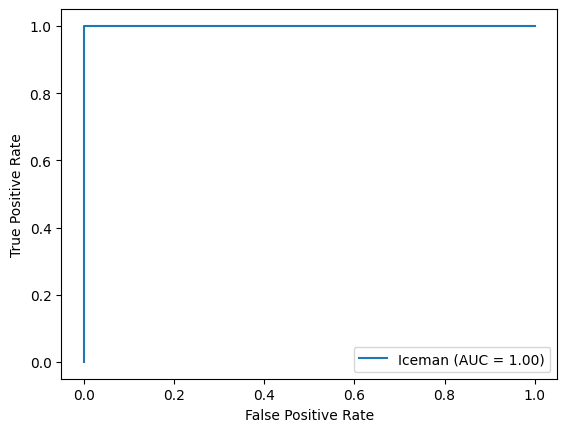

0.49980011757789533


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix

S = np.concatenate((distances_X_test, distances_adversarial_examples))

fpr, tpr, thresholds = roc_curve(test_lab_sym, S)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Iceman')
display.plot()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[optimal_idx]
print(threshold)

## Then we evaluate using Iceman! 

In [ ]:
def IDS(x, threshold):
    S = distance(x)
    predictions, preds = [], model1.predict(np.asarray(x))
    for score, pred in zip(S, preds):
        if score <= threshold:
            predictions.append(pred)
        else:
            predictions.append(abs(1-pred))
    return predictions

In [ ]:
y_pred = IDS(test_set, threshold=0.4997)

In [ ]:
fpr, tpr, thresholds = roc_curve(test_lab_sym, S)
roc_auc = auc(fpr, tpr)
print("Acc: ", round(accuracy_score(y_pred, test_lab), 3), "\nF1-Score: ", round(f1_score(y_pred, test_lab), 3), "\nMCC: ", round(matthews_corrcoef(y_pred, test_lab),3))
print("Rec: ", round(recall_score(y_pred, test_lab), 3), "\nPrec: ", round(precision_score(y_pred, test_lab), 3), "\nAUC: ", round(roc_auc, 3))
fpr, tpr, thresholds = roc_curve(test_lab_sym, S)
fnr = 1 - tpr
eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("Equal Error Rate: ", round(eer,3))
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_lab, y_pred).ravel()
# Calculate rates
tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fnr = fn / (fn + tp)  # False Negative Rate
# Print rates
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Acc:  1.0 
F1-Score:  1.0 
MCC:  1.0
Rec:  1.0 
Prec:  1.0 
AUC:  1.0
Equal Error Rate:  0.0
True Positive Rate (TPR): 1.000
True Negative Rate (TNR): 1.000
False Positive Rate (FPR): 0.000
False Negative Rate (FNR): 0.000


## Alert Management Stuff!

In [ ]:
true_positives = X_sampled[y_sampled == 1] # True Attack. Investigate!
true_negatives = X_sampled[y_sampled == 0] # True Benign. Do Nothing!
false_positives = [example for example, label in zip(adversarial_examples, true_labels) if label == 0] # Evasion (true_label = benign, pred = attack). Caution!
false_negatives = [example for example, label in zip(adversarial_examples, true_labels) if label == 1] # Evasion (true_label = attack, pred = benign). Investigate!

print("Number of False Negatives:", len(false_negatives))

exp_newset = np.concatenate((true_positives, true_negatives, false_positives))
exp_newlab = np.concatenate((np.full(len(true_positives), 1), np.full(len(true_negatives), 0), np.full(len(false_positives), 3)))

Number of False Negatives: 0


In [ ]:
def IDS_alert(x, threshold, filter = False):
    S = distance(x)
    predictions, preds = [], model1.predict(np.asarray(x))
    for score, pred in zip(S, preds):
        if score <= threshold:
            if pred == 1:
                predictions.append('tp' if filter else 1) # TP
            else:
                predictions.append('tn' if filter else 0) # TN
        else:
            if pred == 1:
                predictions.append('fp' if filter else 3) # FP
            else:
                predictions.append('fn' if filter else 2) # FN
    return predictions

In [ ]:
from sklearn.metrics import classification_report

y_pred = IDS_alert(exp_newset, threshold=0.4997)

# Print classification report
print(classification_report(exp_newlab, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3776
           1       1.00      1.00      1.00      3776
           3       1.00      1.00      1.00      7552

    accuracy                           1.00     15104
   macro avg       1.00      1.00      1.00     15104
weighted avg       1.00      1.00      1.00     15104



In [ ]:
exp_newlab_filter = np.concatenate((np.full(len(true_positives), 'tp'), np.full(len(true_negatives), 'tn'), np.full(len(false_positives), 'fp')))

y_pred = IDS_alert(exp_newset, threshold=0.4997, filter=True)

# Print classification report
print(classification_report(exp_newlab_filter, y_pred))

              precision    recall  f1-score   support

          fp       1.00      1.00      1.00      7552
          tn       1.00      1.00      1.00      3776
          tp       1.00      1.00      1.00      3776

    accuracy                           1.00     15104
   macro avg       1.00      1.00      1.00     15104
weighted avg       1.00      1.00      1.00     15104



## Now we evaluate performance using VERITAS

In [ ]:
import veritas

def veritas_attack(model, samples, labels, epsilon, timeout=1, search_steps=100, verbose=False):
    adversarial_examples, true_labels = [], []
    assert len(np.unique(np.asarray(y_test))), "Input must be a binary-classification problem with labels 0/1"
    assert np.min(X_test_nr)>=0 and np.max(X_test_nr)<=1.0, "Input Dataset must be Min-Max Normalised"
    at = veritas.get_addtree(model)
    print("\nFinding Adversarial Examples using Veritas:")
    for i in tqdm(range(len(labels))):
        base_example = samples[i]
        true_label = labels[i]
        if model.predict([base_example]) != true_label:
            if verbose:
                print(i, "Skipping Misclassified Sample","\n")
            continue
        heur = veritas.HeuristicType.MAX_OUTPUT if true_label == 0 else veritas.HeuristicType.MIN_OUTPUT
        config = veritas.Config(heur)
        config.ignore_state_when_worse_than = 0.0
        prune_box = [veritas.Interval(max(0.0, x-epsilon), min(1.0, x+epsilon)) for x in base_example]
        search = config.get_search(at, prune_box)
        stop_reason = search.step_for(timeout, search_steps) 
        while search.num_solutions() == 0:
            if search.steps(search_steps) == veritas.StopReason.NO_MORE_OPEN or stop_reason:
                if verbose:
                    print(i, "Timeout & Skipped","\n") 
                break
        if search.num_solutions() > 0:
            sol = search.get_solution(0)
            adv_example = veritas.get_closest_example(sol, base_example, eps=1e-4)
            predicted_label = int(model.predict([adv_example]))
            l_inf = np.max(np.abs(base_example - adv_example))
            if int(predicted_label) != int(true_label) and l_inf < epsilon:
                adversarial_examples.append(adv_example)
                true_labels.append(true_label)
                if verbose:
                    print(i, "True Label:", str(true_label), "--> Adversarial Label:", str(predicted_label), "L-inf:", l_inf, "\n")
            else:
                if verbose:
                    print(i, "Debugging Needed","\n") 
                    break
        else:
            if verbose:
                pass
                print(i, "No Adversarial Example Found","\n")
    print("\nFound:", len(adversarial_examples), "| Split:", Counter(true_labels))
    return adversarial_examples, true_labels

In [ ]:
adversarial_examples, true_labels = veritas_attack(model1, np.asarray(X_test_nr), np.asarray(y_test_nr), delta)


| XGBOOST's base_score
|   base_score diff std      0.0 OK
|   base_score reported      0.5
|   versus manually detected 0.00031377664163301233
|   abs err                  0.499686223358367
|   rel err                  0.999372446716734
|   (!) base_score NOT THE SAME with relative tolerance 0.0005


Finding Adversarial Examples using Veritas:


100%|██████████| 3776/3776 [01:50<00:00, 34.24it/s] 


Found: 0 | Split: Counter()


Apparently, VERITAS could not find any adversarial examples! 

## Then we evaluate using GROOT!

In [ ]:
from groot.model import GrootRandomForestClassifier
forest = GrootRandomForestClassifier(n_estimators=50, max_depth=5, attack_model = [delta] * X_train.shape[1], random_state=42, verbose=True, n_jobs=10)

forest.fit(np.asarray(X_train), np.asarray(y_train))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   14.6s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   16.1s finished


GrootRandomForestClassifier(attack_model=[0.0001, 0.0001, 0.0001, 0.0001,
                                          0.0001, 0.0001, 0.0001, 0.0001,
                                          0.0001, 0.0001, 0.0001, 0.0001],
                            max_depth=5, n_estimators=50, n_jobs=10,
                            random_state=42, verbose=True)

In [ ]:
y_pred = forest.predict(test_set)

In [ ]:
from sklearn.metrics import roc_auc_score

print("Acc: ", round(accuracy_score(y_pred, test_lab), 3), "\nF1-Score: ", round(f1_score(y_pred, test_lab), 3), "\nMCC: ", round(matthews_corrcoef(y_pred, test_lab),3))
print("Rec: ", round(recall_score(y_pred, test_lab), 3), "\nPrec: ", round(precision_score(y_pred, test_lab), 3), "\nAUC: ", round(roc_auc_score(y_pred, test_lab), 3))
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_lab, y_pred).ravel()
# Calculate rates
tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fnr = fn / (fn + tp)  # False Negative Rate
# Print rates
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Acc:  1.0 
F1-Score:  1.0 
MCC:  1.0
Rec:  1.0 
Prec:  1.0 
AUC:  1.0
True Positive Rate (TPR): 1.000
True Negative Rate (TNR): 1.000
False Positive Rate (FPR): 0.000
False Negative Rate (FNR): 0.000


## Then we evaluate using OC-Score!

In [ ]:
ytrain_pred = model1.predict(X_train) # For the Reference Set
acc_train = accuracy_score(y_train, ytrain_pred)
print(f"Training Accuracy: {acc_train:.3f}")

Training Accuracy: 1.000


In [ ]:
# Find a reference set, e.g. set of correctly classified training examples
xref_mask = ytrain_pred == y_train
xref = X_train[xref_mask]
dtype = np.uint16
idref_train = model1.apply(xref).astype(dtype)

In [ ]:
exp_df = pd.DataFrame(test_set, columns=X_test.columns)
idref_exp = model1.apply(exp_df).astype(dtype)

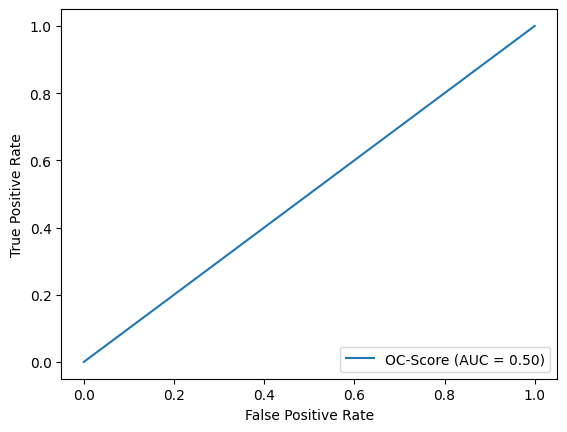

1


In [ ]:
import ocscore

S = ocscore.ocscores(idref_train, idref_exp)

fpr, tpr, thresholds = roc_curve(test_lab_sym, S, drop_intermediate = False)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='OC-Score')
display.plot()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
threshold = round(thresholds[optimal_idx], 3)
print(threshold)

In [ ]:
def OC_predict(x, refset, threshold):
    x = pd.DataFrame(x, columns=X_test.columns)
    testset = model1.apply(x).astype(dtype)
    S = ocscore.ocscores(refset, testset)
    predictions, preds = [], model1.predict(np.asarray(x))
    for score, pred in zip(S, preds):
        if score <= threshold:
            predictions.append(pred)
        else:
            predictions.append(abs(1-pred))
    return predictions

In [ ]:
y_pred = OC_predict(test_set, idref_train, threshold)

In [ ]:
fpr, tpr, thresholds = roc_curve(test_lab_sym, S)
roc_auc = auc(fpr, tpr)
print("Acc: ", round(accuracy_score(y_pred, test_lab), 3), "\nF1-Score: ", round(f1_score(y_pred, test_lab), 3), "\nMCC: ", round(matthews_corrcoef(y_pred, test_lab),3))
print("Rec: ", round(recall_score(y_pred, test_lab), 3), "\nPrec: ", round(precision_score(y_pred, test_lab), 3), "\nAUC: ", round(roc_auc, 3))
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_lab, y_pred).ravel()
# Calculate rates
tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fnr = fn / (fn + tp)  # False Negative Rate
# Print rates
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Acc:  0.5 
F1-Score:  0.5 
MCC:  0.333
Rec:  0.333 
Prec:  1.0 
AUC:  0.5
True Positive Rate (TPR): 1.000
True Negative Rate (TNR): 0.333
False Positive Rate (FPR): 0.667
False Negative Rate (FNR): 0.000


## Timing Experiments!

In [ ]:
runs = 100

In [ ]:
times_1_iceman = []

for _ in tqdm(range(runs)):
    time_output = %timeit -o -n 1 -r 1 -q y_pred = IDS(test_set, threshold=0.4997)
    times_1_iceman.append(time_output.average)

with open('/home/ubuntu/IDS/times/times_1_iceman.pkl', 'wb') as f:
    pickle.dump(times_1_iceman, f)
print("Complete!")

Complete!


In [ ]:
times_1_groot = []

for _ in tqdm(range(runs)):
    time_output = %timeit -o -n 1 -r 1 -q y_pred = forest.predict(test_set)
    times_1_groot.append(time_output.average)

with open('/home/ubuntu/IDS/times/times_1_groot.pkl', 'wb') as f:
    pickle.dump(times_1_groot, f)
print("Complete!")

100%|██████████| 100/100 [00:03<00:00, 30.35it/s]

Complete!


In [ ]:
times_1_ocscore = []

for _ in tqdm(range(runs)):
    time_output = %timeit -o -n 1 -r 1 -q y_pred = OC_predict(test_set, idref_train, threshold)
    times_1_ocscore.append(time_output.average)

with open('/home/ubuntu/IDS/times/times_1_ocscore.pkl', 'wb') as f:
    pickle.dump(times_1_ocscore, f)
print("Complete!")

Complete!
